# Machine Learning - Kristianstad University
# Seminar 2: Classification Models 🎵
## Mustafa Al-Bayati and Daniel Jönnson, Group 10
## Goal: Build, analyze, and evaluate classification models

# 1️: Install Libraries (run only in Jupyter)

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 2️: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

# 3️: Load Dataset

In [3]:
df = pd.read_csv('musicdata/comercial.csv')
df

,artist,song,hour,date,popularity,album_name,release_date,total_track_album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Years & Years,It's a Sin,00:58,01/01/2020,43.0,It’s a sin,2021-05-11,1.0,0.596,0.891,0.0,-5.925,0.0,0.0429,0.0350,0.000004,0.1860,0.200,124.986
1,David Fonseca,Someone that Cannot Love,00:54,01/01/2020,31.0,Sing Me Something New,2003-01-01,15.0,0.460,0.528,0.0,-7.249,1.0,0.0268,0.2800,0.000070,0.1310,0.430,151.207
2,Pearl Jam,Just Breathe,00:50,01/01/2020,66.0,Backspacer,2009-09-19,12.0,0.473,0.348,0.0,-11.100,1.0,0.0288,0.7210,0.000074,0.0823,0.283,107.819
3,"Ed Sheeran, Taylor Swift",The Joker and the Queen,00:47,01/01/2020,63.0,The Joker And The Queen (feat. Taylor Swift),2022-02-11,1.0,0.528,0.309,0.0,-7.398,1.0,0.0329,0.9240,0.000002,0.2820,0.307,133.830
4,Seal,Stand by Me,00:43,01/01/2020,38.0,Soul,2008-10-31,12.0,0.734,0.409,9.0,-7.596,1.0,0.0280,0.2460,0.000000,0.1280,0.779,107.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478098,Dua Lipa,Houdini,14:04,31/12/2023,81.0,Radical Optimism,2024-05-03,11.0,0.744,0.789,9.0,-4.876,0.0,0.0590,0.0036,0.001440,0.0947,0.866,116.985
478099,Mark Ambor,Belong Together,15:14,31/12/2023,86.0,Belong Together,2024-02-16,1.0,0.646,0.668,2.0,-5.203,1.0,0.0282,0.4910,0.000000,0.2120,0.640,90.969
478100,"D.A.M.A., Buba Espinho",Casa,15:10,31/12/2023,53.0,CASA,2022-11-25,1.0,0.459,0.463,4.0,-8.050,1.0,0.1110,0.6980,0.000000,0.6490,0.351,148.284
478101,Lost Frequencies,Are You with Me,15:08,31/12/2023,69.0,Less Is More,2016-10-21,16.0,0.763,0.608,5.0,-8.100,0.0,0.0350,0.2620,0.000025,0.1200,0.393,121.020


# 4️: Data Cleaning

In [4]:
# Remove exact duplicates
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

After dropping duplicates: (478103, 19)


In [5]:
# Replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [6]:
# Drop columns with >30% missing values
missing_frac = df.isnull().mean()
drop_missing = missing_frac[missing_frac > 0.3].index.tolist()
df.drop(columns=drop_missing, inplace=True)

In [7]:
# Drop clearly non-informative columns
drop_cols = ['artist', 'song', 'hour', 'date', 'album_name', 'release_date']
drop_present = [c for c in drop_cols if c in df.columns]
df.drop(columns=drop_present, inplace=True)
print("After cleaning columns:", df.shape)

After cleaning columns: (478103, 13)


# 5️: Handle Outliers (IQR Method)

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_no_outliers = df.copy()
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_no_outliers[col] = np.clip(df[col], lower, upper)
print("Outliers capped using IQR method.")

Outliers capped using IQR method.


# 6️: Define Target Variable

In [9]:
if 'popularity' not in df_no_outliers.columns:
    raise ValueError("'popularity' column not found!")

median_pop = df_no_outliers['popularity'].median()
df_no_outliers['popularity_target'] = (df_no_outliers['popularity'] >= median_pop).astype(int)
print("Target distribution:\n", df_no_outliers['popularity_target'].value_counts(normalize=True))

Target distribution:
 popularity_target
1    0.503634
0    0.496366
Name: proportion, dtype: float64


# 7️: Select Features & Target

In [10]:
feature_cols = [c for c in numeric_cols if c not in ['popularity', 'popularity_target']]
X = df_no_outliers[feature_cols]
y = df_no_outliers['popularity_target']
print(f"Feature columns: {feature_cols}")

Feature columns: ['total_track_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


# 8️: Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (334672, 12) Test shape: (143431, 12)


# 9️: Imputation & Scaling

In [12]:
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)

# 1️0: Evaluation Function

In [13]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name}: Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# 1️1: Baseline Models

In [14]:
# Logistic Regression - baseline
lr = LogisticRegression(random_state=SEED, solver='liblinear')
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_metrics = evaluate_model("Logistic Regression (baseline)", y_test, lr_pred)

# Decision Tree - baseline (Gini)
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=SEED)
dt_gini.fit(X_train_imp, y_train)
gini_pred = dt_gini.predict(X_test_imp)
gini_metrics = evaluate_model("Decision Tree (Gini baseline)", y_test, gini_pred)

# Decision Tree - baseline (Entropy)
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=SEED)
dt_entropy.fit(X_train_imp, y_train)
entropy_pred = dt_entropy.predict(X_test_imp)
entropy_metrics = evaluate_model("Decision Tree (Entropy baseline)", y_test, entropy_pred)

Logistic Regression (baseline): Accuracy=0.670, Precision=0.658, Recall=0.719, F1=0.687
Decision Tree (Gini baseline): Accuracy=0.884, Precision=0.833, Recall=0.963, F1=0.893
Decision Tree (Entropy baseline): Accuracy=0.857, Precision=0.946, Recall=0.759, F1=0.842


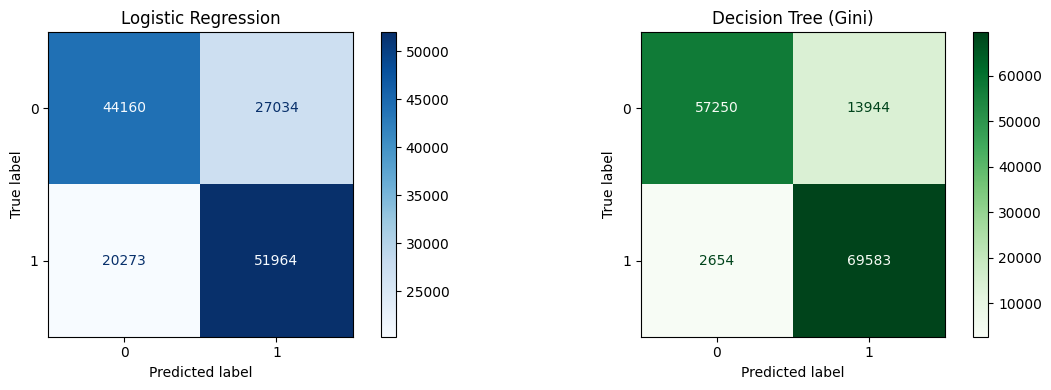

In [15]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_pred)).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Logistic Regression")
ConfusionMatrixDisplay(confusion_matrix(y_test, gini_pred)).plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("Decision Tree (Gini)")
plt.tight_layout()
plt.show()

# 1️2: Compare Decision Tree: Gini vs Entropy


Decision Tree Comparison:
Decision Tree (Entropy): Accuracy=0.857, Precision=0.946, Recall=0.759, F1=0.842


,Accuracy,Precision,Recall,F1
Gini,0.884279,0.833060,0.963260,0.893441
Entropy,0.856726,0.945924,0.758905,0.842156


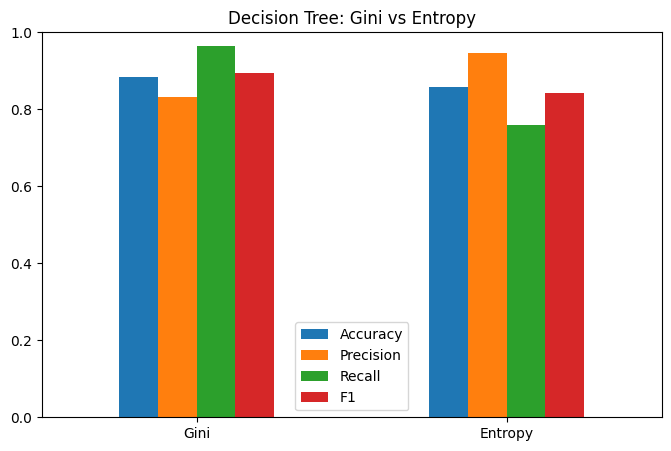

In [16]:
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=SEED)
dt_entropy.fit(X_train_imp, y_train)
entropy_pred = dt_entropy.predict(X_test_imp)

print("\nDecision Tree Comparison:")
entropy_metrics = evaluate_model("Decision Tree (Entropy)", y_test, entropy_pred)

compare_df = pd.DataFrame([gini_metrics, entropy_metrics], index=["Gini", "Entropy"])
display(compare_df)

compare_df.plot(kind='bar', figsize=(8,5), rot=0, title='Decision Tree: Gini vs Entropy')
plt.ylim(0,1)
plt.show()

# 1️3: Hyperparameter Tuning

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Decision Tree tuning
dt_param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [10, 20, 50]
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED),
    dt_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
grid_dt.fit(X_train_imp, y_train)
best_dt = grid_dt.best_estimator_

print("Best DT params (regularized):", grid_dt.best_params_)

Best DT params (regularized): {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}


In [18]:
# Logistic Regression tuning
lr_param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(solver='liblinear', random_state=SEED),
                       lr_param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)

Best Logistic Regression Params: {'C': 0.1}


In [19]:
# Evaluate Tuned Models
best_dt_pred = best_dt.predict(X_test_imp)
best_lr_pred = best_lr.predict(X_test_scaled)

best_dt_metrics = evaluate_model("Decision Tree (regularized)", y_test, best_dt_pred)
best_lr_metrics = evaluate_model("Logistic Regression (tuned)", y_test, best_lr_pred)


Decision Tree (regularized): Accuracy=0.973, Precision=0.964, Recall=0.984, F1=0.974
Logistic Regression (tuned): Accuracy=0.670, Precision=0.658, Recall=0.719, F1=0.687


# 1️4: Feature Importance

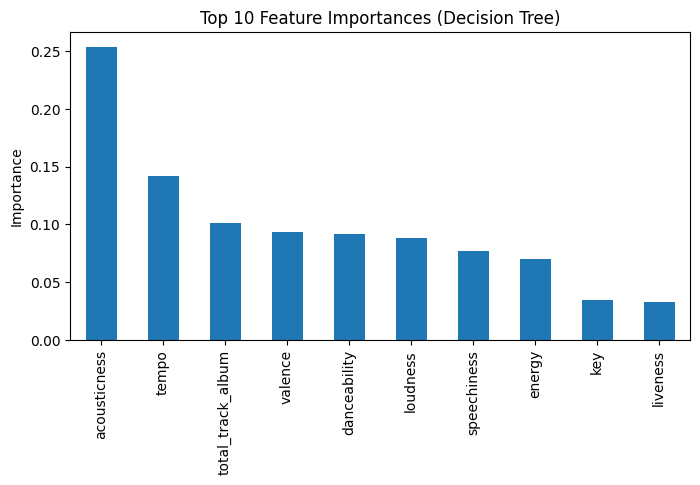

In [20]:
dt_importances = pd.Series(best_dt.feature_importances_, index=X_train_imp.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
dt_importances.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.ylabel("Importance")
plt.show()

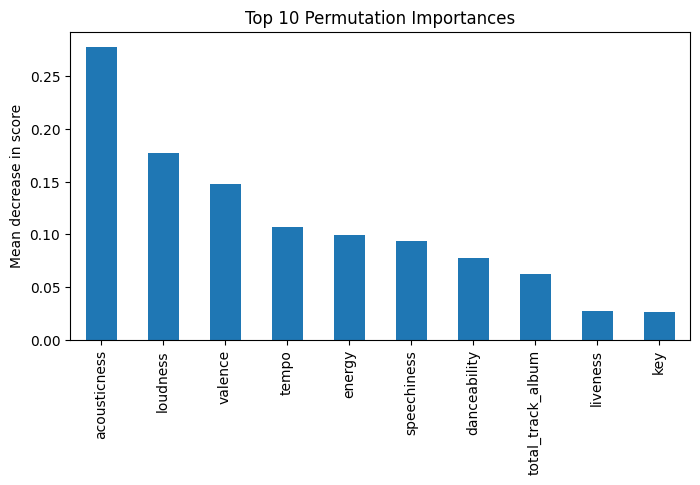

In [21]:
perm = permutation_importance(best_dt, X_test_imp, y_test, n_repeats=10, random_state=SEED)
perm_importances = pd.Series(perm.importances_mean, index=X_test_imp.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
perm_importances.head(10).plot(kind='bar')
plt.title("Top 10 Permutation Importances")
plt.ylabel("Mean decrease in score")
plt.show()

# 1️5: Visualize Tuned Decision Tree

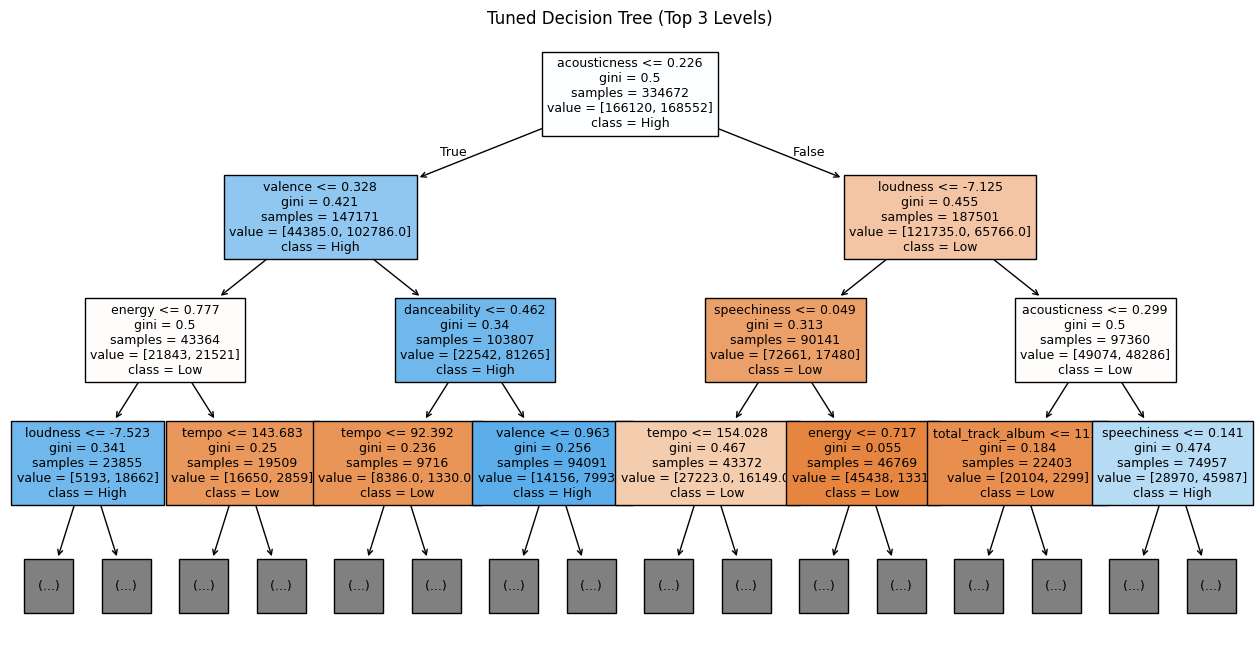

In [22]:
plt.figure(figsize=(16,8))
plot_tree(best_dt, feature_names=X_train_imp.columns, class_names=['Low', 'High'],
          filled=True, max_depth=3, fontsize=9)
plt.title("Tuned Decision Tree (Top 3 Levels)")
plt.show()

# 1️6: Final Summary

In [23]:
final_summary = pd.DataFrame({
    "LogReg (baseline)": lr_metrics,
    "LogReg (tuned)": best_lr_metrics,
    "DT (Gini baseline)": gini_metrics,
    "DT (Entropy baseline)": entropy_metrics,
    "DT (tuned)": best_dt_metrics
}).T

display(final_summary)


,Accuracy,Precision,Recall,F1
LogReg (baseline),0.670176,0.657789,0.719354,0.687195
LogReg (tuned),0.670176,0.657789,0.719354,0.687195
DT (Gini baseline),0.884279,0.833060,0.963260,0.893441
DT (Entropy baseline),0.856726,0.945924,0.758905,0.842156
DT (tuned),0.973479,0.963846,0.984260,0.973946


Conclusions
----------------------------

Model Performance:

Logistic Regression (baseline and tuned) performed moderately with 67% accuracy, showing limited ability to capture complex patterns in the data. Tuning did not improve its performance.

Decision Trees (DT) showed significantly higher performance:

Gini baseline: High recall (96%) but slightly lower precision (83%), meaning it identifies most positives but produces some false positives.

Entropy baseline: Very high precision (95%) but lower recall (76%), meaning it avoids false positives but misses more actual positives.

Tuned DT: Achieved 97% accuracy, 96% precision, 98% recall, and 97% F1-score, demonstrating balanced and superior performance across all metrics.

Metric Insights:

Precision-recall tradeoff is evident in the baseline DT models.

F1-score confirms that the tuned DT provides the best balance between precision and recall.